<h1>Data Loading</h1>

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
train_dir = '/content/drive/MyDrive/file3/train'
valid_dir = '/content/drive/MyDrive/file3/valid'

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/file3/train/_classes.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/file3/valid/_classes.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/file3/train/_classes.csv'

In [ ]:
train_df.head(5)

NameError: name 'train_df' is not defined

<h1>Modelling</h1>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import Dropout
from keras.regularizers import l2

In [ ]:
input_shape = (224, 224, 3)
batch_size = 32
epochs = 30
num_classes = 12

In [ ]:
def get_label(row):
    return row.iloc[1:].values.astype(np.float32)

In [ ]:
train_df['label'] = train_df.apply(get_label, axis=1)
valid_df['label'] = valid_df.apply(get_label, axis=1)
test_df['label'] = test_df.apply(get_label, axis=1)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, directory, batch_size, target_size, datagen, shuffle=True):
        self.dataframe = dataframe
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.datagen = datagen
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe) // self.batch_size

    def __getitem__(self, index):
        batch = self.dataframe.iloc[index*self.batch_size:(index+1)*self.batch_size]
        images = []
        labels = []
        for i, row in batch.iterrows():
            img = tf.keras.preprocessing.image.load_img(os.path.join(self.directory, row['filename']), target_size=self.target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = self.datagen.standardize(img)
            images.append(img)
            labels.append(row['label'])
        return np.array(images, dtype='float32'), np.array(labels, dtype='float32')

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

In [ ]:
train_generator = CustomDataGenerator(
    dataframe=train_df,
    directory=train_dir,
    batch_size=batch_size,
    target_size=input_shape[:2],
    datagen=train_datagen
)

valid_generator = CustomDataGenerator(
    dataframe=valid_df,
    directory=valid_dir,
    batch_size=batch_size,
    target_size=input_shape[:2],
    datagen=valid_datagen,
    shuffle=False
)


test_generator = CustomDataGenerator(
    dataframe=test_df,
    directory=test_dir,
    batch_size=batch_size,
    target_size=input_shape[:2],
    datagen=valid_datagen,
    shuffle=False
)

<h1>Transfer Learning dengan MobileNetV2</h1>

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
52/52 [==============================] - 636s 12s/step - loss: 1.4594 - accuracy: 0.5391 - val_loss: 1.1015 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 2/30
52/52 [==============================] - 94s 2s/step - loss: 0.6615 - accuracy: 0.8065 - val_loss: 0.9106 - val_accuracy: 0.7366 - lr: 0.0010
Epoch 3/30
52/52 [==============================] - 91s 2s/step - loss: 0.4017 - accuracy: 0.8840 - val_loss: 0.8956 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 4/30
52/52 [==============================] - 96s 2s/step - loss: 0.2932 - accuracy: 0.9195 - val_loss: 0.8495 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 5/30
52/52 [==============================] - 90s 2s/step - loss: 0.1805 - accuracy: 0.9537 - val_loss: 0.8456 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 6/30
52/52 [==============================] - 91s 2s/step - loss: 0.1355 - accuracy: 0.9657 - val_loss: 0.8796 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 7/30
52/52 [==============================] - 89s 2s/step - loss: 0.1058 -

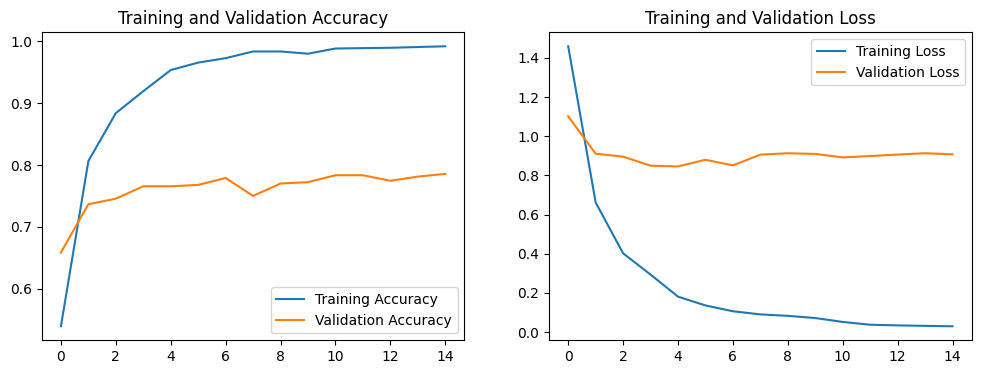

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)


In [ ]:
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('trained_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

print("Model converted to TensorFlow Lite successfully!")

Model converted to TensorFlow Lite successfully!


<h1>Fine Tuning</h1>
<h2><b>Hasil Lebih Jelek</b></h2>


In [ ]:
'''
def unfreeze_model(model, num_unfreeze):
    for layer in model.layers[-num_unfreeze:]:
        layer.trainable = True
'''

'\ndef unfreeze_model(model, num_unfreeze):\n    for layer in model.layers[-num_unfreeze:]:\n        layer.trainable = True\n'

In [ ]:
#unfreeze_model(base_model, 30)

In [ ]:
'''
for layer in base_model.layers[-60:]:
    layer.trainable = True
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
'''

"\nfor layer in base_model.layers[-60:]:\n    layer.trainable = True\nmodel.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])\n"

In [ ]:
'''
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
'''

'\ndef lr_scheduler(epoch, lr):\n    if epoch < 10:\n        return lr\n    else:\n        return lr * tf.math.exp(-0.1)\n'

In [ ]:
'''
checkpoint = ModelCheckpoint('fine_tuned_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=5e-5)

callbacks = [checkpoint, early_stopping, reduce_lr]
'''

"\ncheckpoint = ModelCheckpoint('fine_tuned_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')\nearly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)\nreduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=5e-5)\n\ncallbacks = [checkpoint, early_stopping, reduce_lr]\n"

In [ ]:
'''
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs
'''

'\nfine_tune_epochs = 20\ntotal_epochs = epochs + fine_tune_epochs\n'

In [ ]:
'''
history_fine = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks,
    verbose=1
)
'''

'\nhistory_fine = model.fit(\n    train_generator,\n    validation_data=valid_generator,\n    epochs=total_epochs,\n    initial_epoch=history.epoch[-1],\n    callbacks=callbacks,\n    verbose=1\n)\n'